## SCVI integration was performed by Xiaohan, here comparing to harmony integration

``` bash
rsync -azvhp /QRISdata/Q5935/nikita/scdata/2025-04-29_Raw-data-for-scvi/NRclean_scVI_Data.h5ad /scratch/user/s4436039/scdata/Myeloid_Objects/ 
```

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce
from matplotlib.pyplot import rc_context
import seaborn as sns

In [2]:
#show current directory 
os.chdir('/scratch/user/s4436039/scdata/Myeloid_Objects')
os.getcwd()

'/scratch/user/s4436039/scdata/Myeloid_Objects'

In [3]:
sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [4]:
ddl.logging.print_header()

dandelion==0.3.8 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.2 networkx==3.3 scipy==1.14.0


In [5]:
# read in data
data_harmony = sc.read_h5ad('/scratch/user/s4436039/scdata/Myeloid_Objects/NRclean_clustered2.h5ad')
data_scvi = sc.read_h5ad('/scratch/user/s4436039/scdata/Myeloid_Objects/NRclean_scVI_Data.h5ad')

In [6]:
data_harmony

AnnData object with n_obs × n_vars = 498023 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'cancer_type_broad', 'clean-leiden_0.8', 'clean-subcluster', 'clean-subcluster-v2', 'YS_sig', 'HSC_sig', 'CD5nDC2_up_vDC3', 'DC3_up_vCD5nDC2', 'CD5pDC2_up_vDC3', 'DC3_up_vCD5pDC2', 'DC3_up_vMono', 'Mono_up_vDC3', 'DC1_sig', 'DC2_sig', 'DC3_sig', 'DC_Axl_sig', 'DC2_up_DC3', 'DC3_up_DC2', 'mregDC_sig', 'cDC1_mregDC', 'cDC2_mregDC', 'NR_annotati

In [7]:
data_harmony.obsm["X_pca_harmony"].shape

(498023, 60)

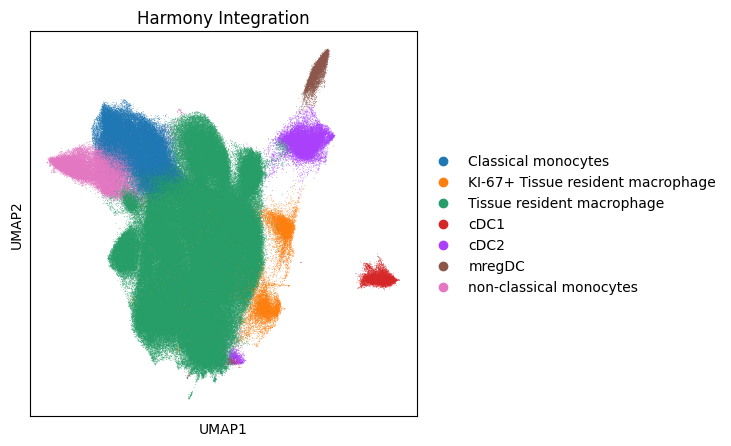

In [13]:
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(data_harmony, 
            color="NR_annotations_simple", 
            size=1, 
            title="Harmony Integration")

In [8]:
data_scvi

AnnData object with n_obs × n_vars = 498023 × 1264
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment', '_scvi_batch', '_scvi_labels'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'integration_id_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
data_scvi.obsm["X_scVI"].shape

(498023, 30)

In [10]:
# For scvi data, assign the new PCs to the standard PCA slot
data_scvi.obsm['X_pca'] = data_scvi.obsm['X_scVI']

In [11]:
## Computing neighbourhood graph - here UMAP
sc.pp.neighbors(data_scvi, n_neighbors=10, n_pcs=30)

In [12]:
sc.tl.umap(data_scvi, min_dist=0.3)  # 0.3 is personal preference

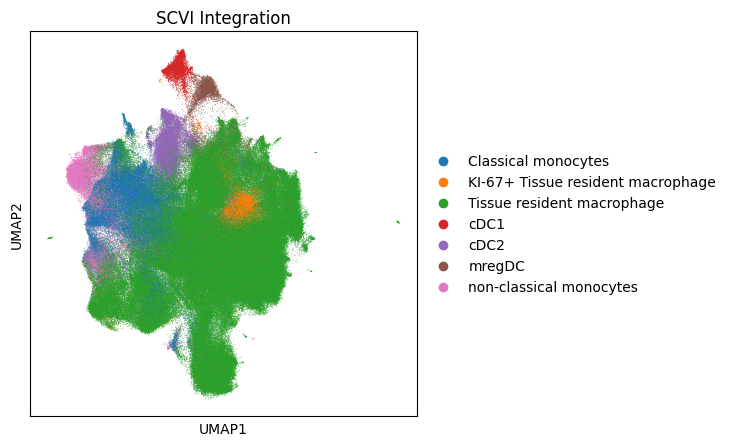

In [14]:
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(data_scvi, 
            color="NR_annotations_simple", 
            size=1, 
            title="SCVI Integration")

In [17]:
## Computing neighbourhood graph 
sc.pp.neighbors(data_scvi, n_neighbors=10, n_pcs=30, use_rep="X_scVI")

In [18]:
sc.tl.umap(data_scvi, min_dist=0.3)  # 0.3 is personal preference

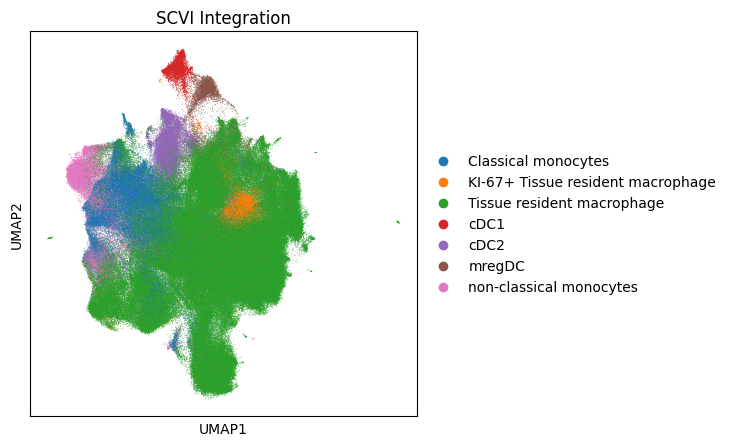

In [19]:
with plt.rc_context({"figure.figsize": (5, 5)}):
    sc.pl.umap(data_scvi, 
            color="NR_annotations_simple", 
            size=1, 
            title="SCVI Integration")

In [20]:
#define function
def cluster_small_multiples(
    data_int, clust_key, size=10, frameon=False, legend_loc=None, **kwargs
):
    tmp = data_int.copy()

    for i, clust in enumerate(data_int.obs[clust_key].cat.categories):
        tmp.obs[clust] = data_int.obs[clust_key].isin([clust]).astype("category")
        tmp.uns[clust + "_colors"] = ["#d3d3d3", data_int.uns[clust_key + "_colors"][i]]

    sc.pl.umap(
        tmp,
        groups=tmp.obs[clust].cat.categories[1:].values,
        color=data_int.obs[clust_key].cat.categories.tolist(),
        size=size,
        frameon=frameon,
        legend_loc=legend_loc,
        **kwargs
    )

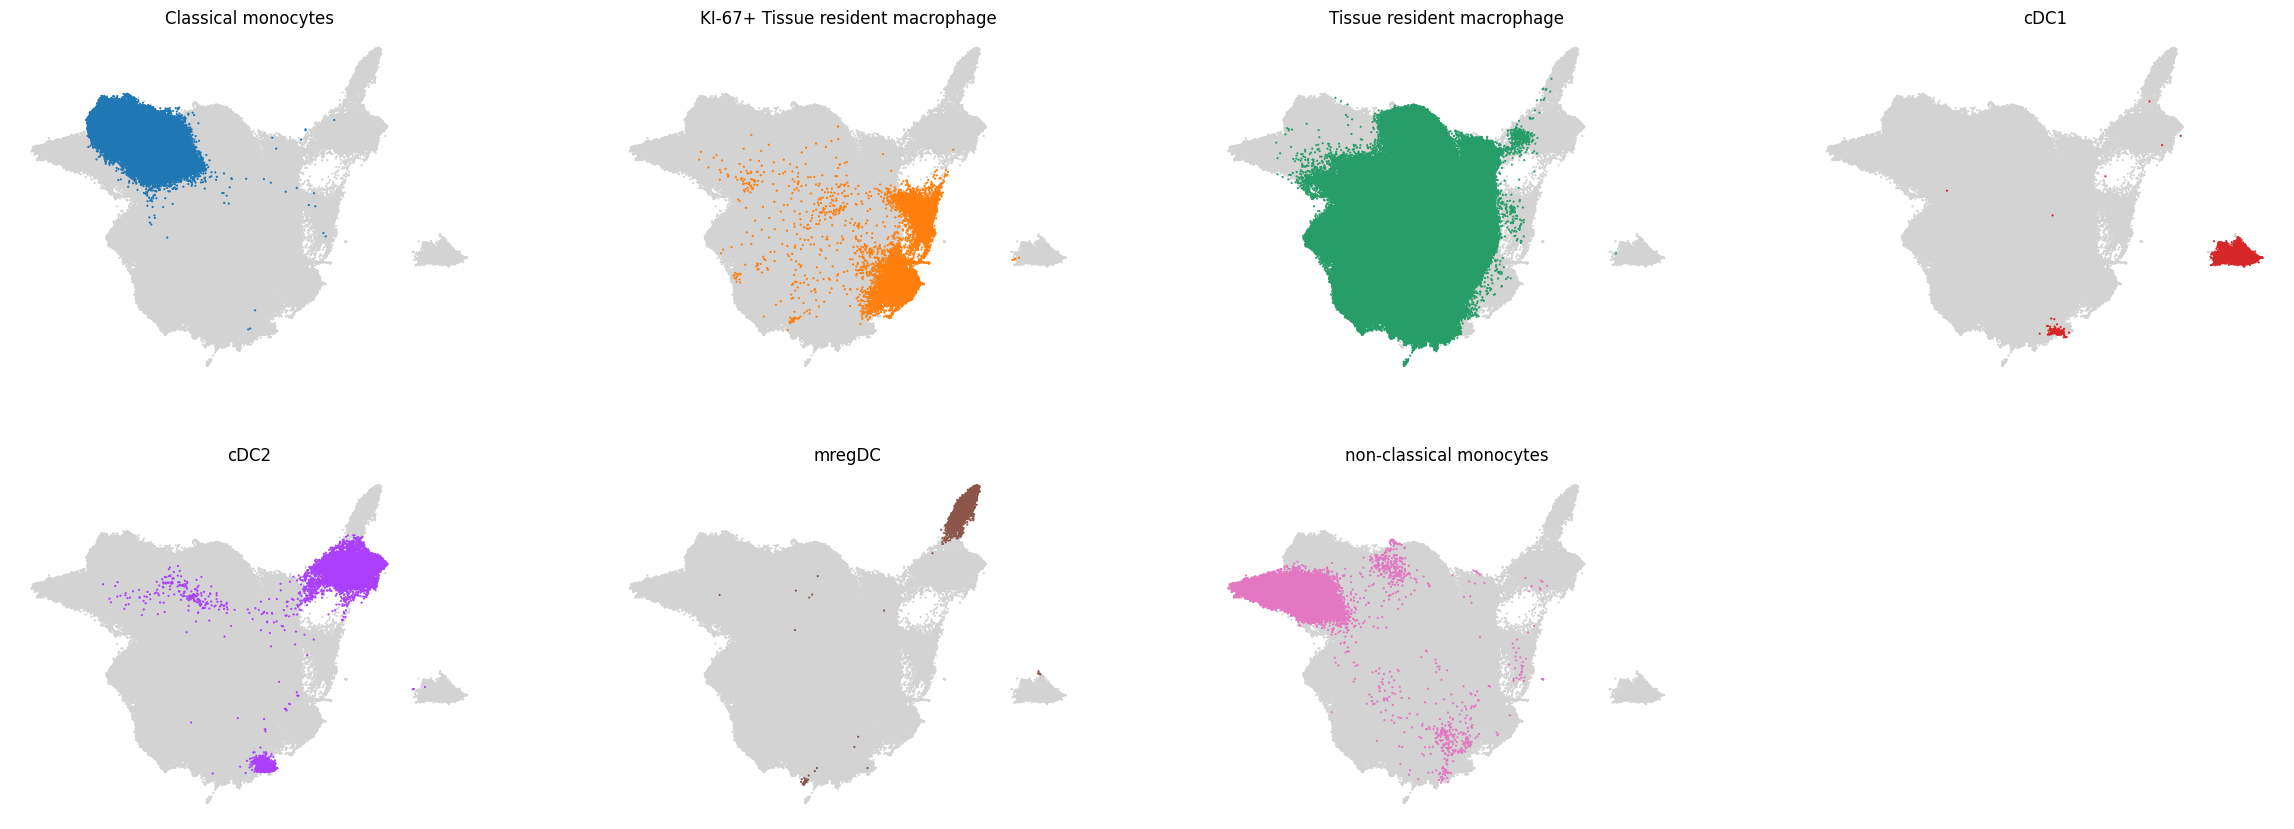

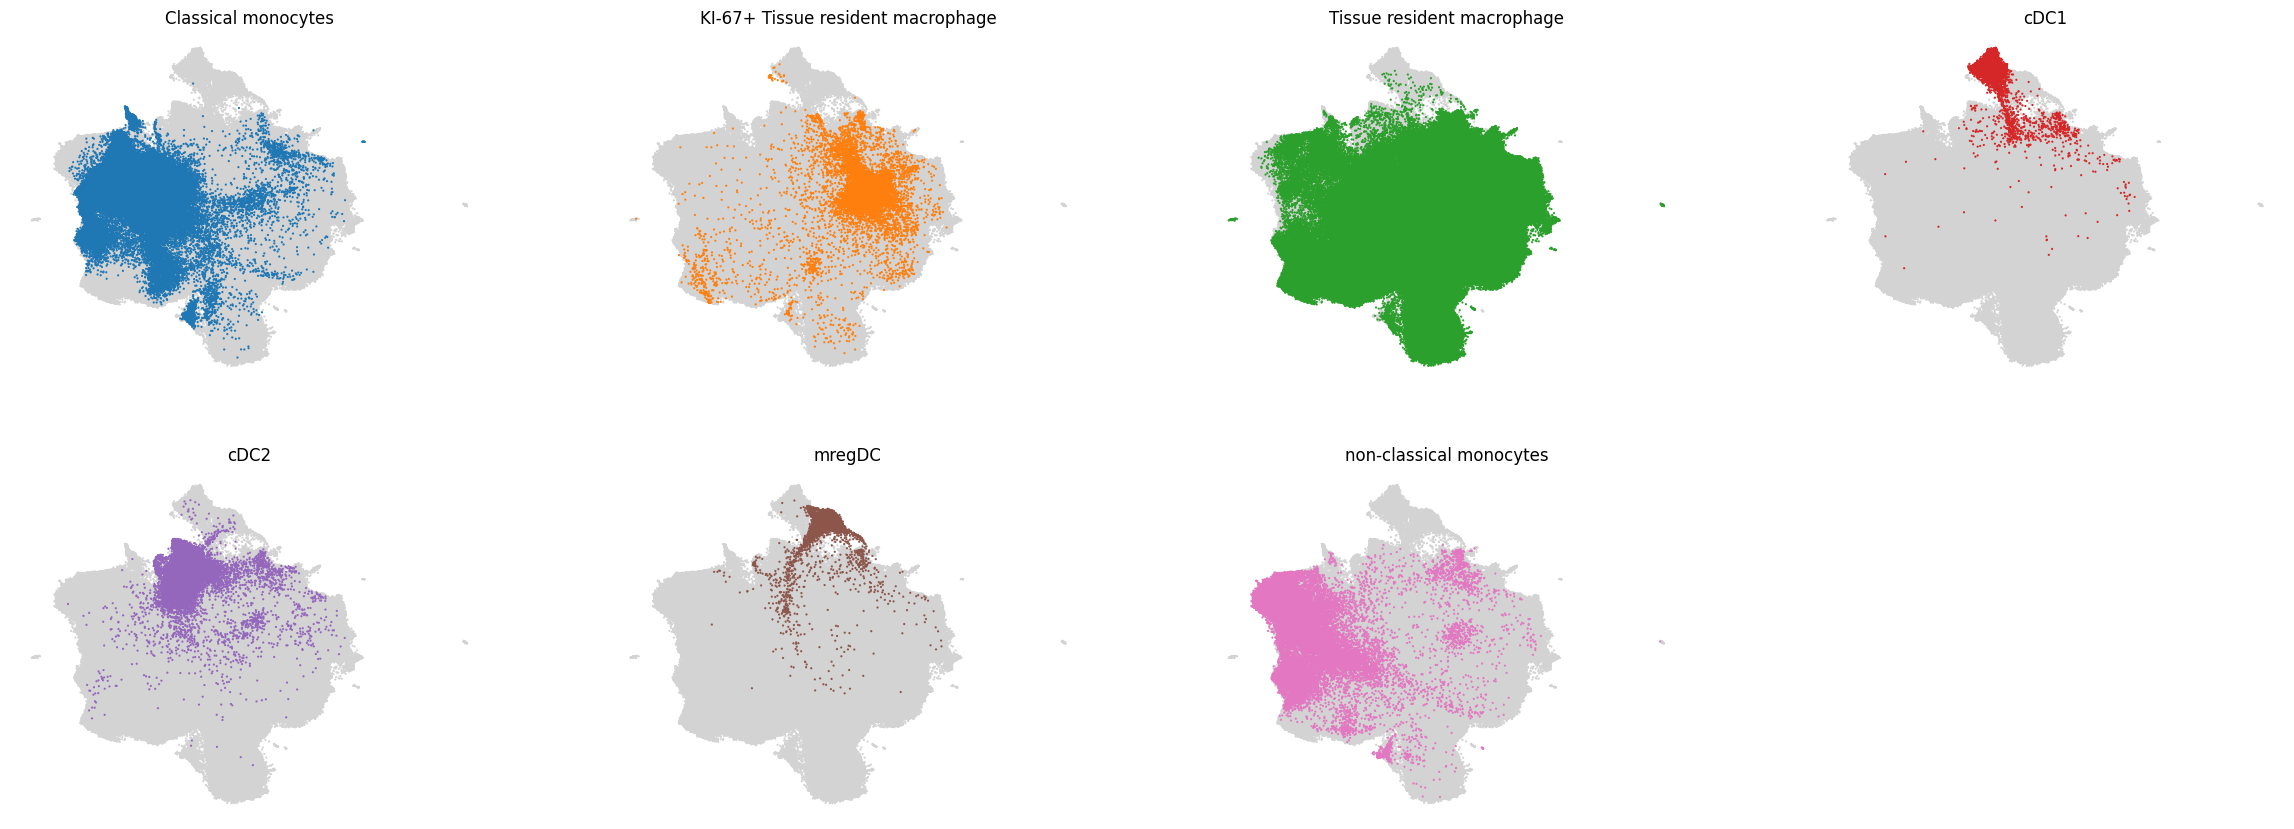

: 

In [ ]:
cluster_small_multiples(data_harmony, "NR_annotations_simple")
cluster_small_multiples(data_scvi, "NR_annotations_simple")